<a href="https://colab.research.google.com/github/Fahad-H36/Caption-Generation-Model/blob/main/Caption_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Loading and Cleaning the Data

In [ ]:
import string

def load_doc(path):
    file = open(path, "r")
    data = file.read()
    file.close()
    return data

def create_set(path):

    data = load_doc(path)

    dataset = {}

    for line in data.split("\n")[1:-1]:

        img, caption = line.split(",", maxsplit=1)
        if img not in dataset:
            dataset[img] = [caption]
        else:
            dataset[img].append(caption)
    return dataset

def clean_data(data_dict):

    table = str.maketrans('', '', string.punctuation)
    for img, captions in data_dict.items():
        for i, cap in enumerate(captions):
            if len(cap)>2:

                cap.replace("-", " ")
                des = cap.split()

                des = [word.lower() for word in des]
                des = [word.translate(table) for word in des]
                des = [word for word in des if(word.isalpha())]

                cap = '<start> ' + " ".join(des) + ' <end>'
                data_dict[img][i] = cap

    return data_dict




def vocab(data_dict):

    images = []
    captions = []
    vocab = set()

    for key in data_dict.keys():

        [vocab.update(d.split()) for d in data_dict[key]]
        images.append(key)
        for i in range(len(data_dict[key])):
            captions.append(data_dict[key][i])

    return vocab, images, captions




In [ ]:
discriptions = create_set("/content/drive/MyDrive/project/captions.txt")
clean_discriptions = clean_data(discriptions)
vocabulary, images, captions = vocab(clean_discriptions)
print(len(vocabulary))
print(len(captions))

8778
40455


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

In [ ]:
tokenizer = Tokenizer( num_words=5000, oov_token='<unk>')
tokenizer.fit_on_texts(captions)
# file = open("/content/drive/MyDrive/project/tokenizer.p", "wb")
# pickle.dump(tokenizer, file)
# file.close()
text_seq = tokenizer.texts_to_sequences(captions)

In [ ]:
from keras.preprocessing import image
from keras.applications.xception import Xception, preprocess_input
from tqdm import tqdm, tqdm_notebook
import numpy as np
import os

In [ ]:
model = Xception(weights='imagenet', include_top=False, pooling='avg')

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
def extract_features(path, model):

    features_dict = {}
    input_shape = (299,299, 3)

    for img in tqdm(os.listdir(path)):
        filename = path + "/" + img
        pic = image.load_img(filename, target_size = (input_shape[0], input_shape[1]))
        pic = image.img_to_array(pic)
        pic = np.expand_dims(pic, axis=0)
        pic = preprocess_input(pic)
        features = model.predict(pic, batch_size=32)
        features_dict[img] = features

    return features_dict

In [ ]:

PATH = "/content/drive/MyDrive/project/images"


feature_data = extract_features(PATH, model)

In [ ]:
import pickle


file = open("/content/drive/MyDrive/project/features.p", "wb")
pickle.dump(feature_data, file)
file.close()

In [ ]:

from tensorflow.keras.utils import to_categorical
import numpy as np

def data_generator(descriptions, features, tokenizer, max_length):

    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            #break

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = [], [], []

    for desc in desc_list:

        seq = tokenizer.texts_to_sequences([desc])
        seq = seq[0]
        for i in range(1, len(seq)):

            in_seq, out_seq = seq[:i], seq[i]

            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [ ]:
import pickle

features = pickle.load(open("/content/drive/MyDrive/project/features.p", "rb"))
# extra_features = pickle.load(open("/content/drive/MyDrive/project/add_features.p", "rb"))
#tokenizer = pickle.load(open("/content/drive/MyDrive/project/tokenizer.p", "rb"))


In [ ]:
features["1000268201_693b08cb0e.jpg"].shape

(1, 2048)

In [ ]:
print(list(features[f] for f in list(features.keys())[:2]))
print(list(extra_features[f] for f in list(extra_features.keys())[:2]))

[array([[0.36452794, 0.12713662, 0.0013574 , ..., 0.221817  , 0.01178991,
        0.24176797]], dtype=float32), array([[0.00751702, 0.22909527, 0.        , ..., 0.3349492 , 0.12825981,
        0.01659334]], dtype=float32)]
[array([[0.03959067, 0.04155305, 0.01061387, ..., 0.00063564, 0.05146623,
        0.30769932]], dtype=float32), array([[0.11574404, 0.02732422, 0.        , ..., 0.12854207, 0.00754042,
        0.02283945]], dtype=float32)]


In [ ]:
n = 0
train_features = {}
test_features = {}
train_captions = {}
test_captions = {}
for key in clean_discriptions.keys():

  if n < 8000:
    train_features[key] = features[key]
    train_captions[key] = clean_discriptions[key]
  else:
    test_features[key] = features[key]
    test_captions[key] = clean_discriptions[key]
  n+=1


# for key in clean_discriptions.keys():
#   if key in list(dataset.keys()):
#     print(key)
  # print(key if key in list(dataset.keys()))



Creating the Model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from keras.layers.merge import add
from keras.models import load_model


def create_model(vocab_size, max_length):
    inputs1 = layers.Input(shape=(2048,))
    fe1 = layers.Dropout(0.2)(inputs1)
    fe2 = layers.Dense(512, activation='relu')(fe1)
    fe3 = layers.Dropout(0.3)(fe2)
    fe4 = layers.Dense(256, activation='relu')(fe3)

    inputs2 = layers.Input(shape=(max_length,))
    se1 = layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = layers.Dropout(0.4, name='caption_dropout')(se1)
    se3 = layers.LSTM(256)(se2)

    decoder1 = add([fe4, se3])
    decoder2 = layers.Dense(256, activation='relu')(decoder1)
    #decoder3 = layers.Dropout(0.2)(decoder2)
    decoder4 = layers.Dense(128, activation='relu')(decoder2)
    outputs = layers.Dense(vocab_size, activation='softmax')(decoder4)

    model = Model(inputs=([inputs1, inputs2]), outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training the Model Block

In [ ]:
import os
from tqdm import tqdm
from keras.models import load_model
from keras import backend as K

vocab_size=len(tokenizer.word_index)
print(vocab_size)
max_length = 32

mdl = create_model(vocab_size, max_length)

epochs = 15

steps = len(train_captions)

for i in tqdm(range(epochs)):
    generator = data_generator(train_captions, train_features, tokenizer, max_length)
    mdl.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    mdl.save("/content/drive/MyDrive/project/newer_models/model_" + str(i) + ".h5")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
def generateCaption(photo, caption_model):
    in_text = "start"
    max_length = 32
    for i in range(max_length):
        sequence = [tokenizer.word_index[w] for w in in_text.split()]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        in_text += ' ' + word
        if word == "end":
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def extract_test_features(photo, model):
        input_shape = (299,299,3)
        pic = image.load_img(photo, target_size = (input_shape[0], input_shape[1]))
        pic = image.img_to_array(pic)
        pic = np.expand_dims(pic, axis=0)
        #pic = preprocess_input(pic)
        pic = pic/127.5
        pic = pic - 1.0
        features = model.predict(image)
        return features

def extract_features_test(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4:
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature



<!-- Loading  -->

Loading Model That I have trained before hand

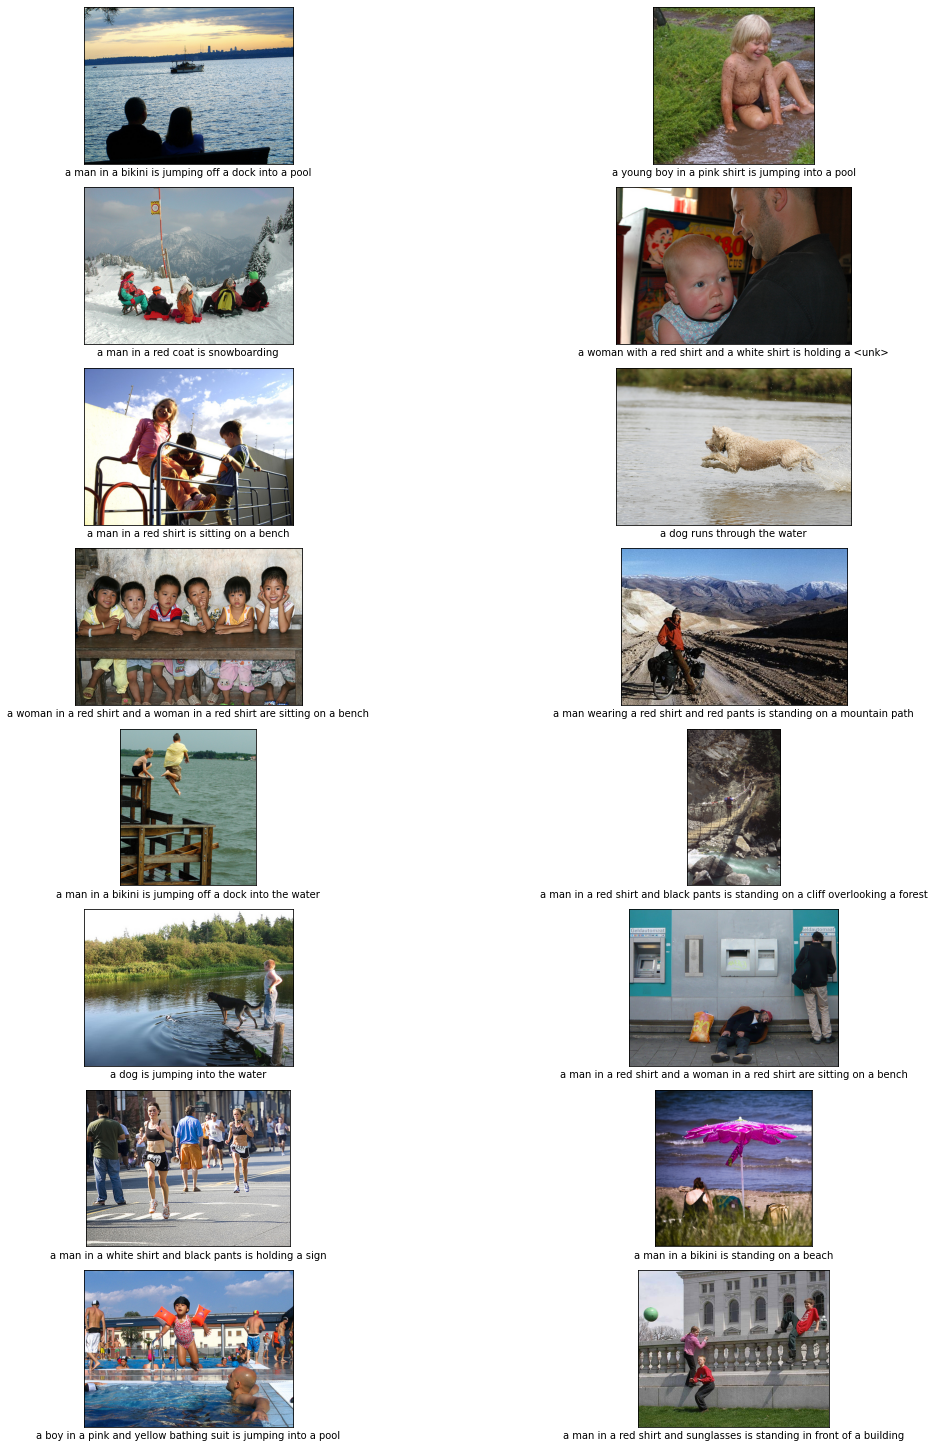

In [ ]:

%matplotlib inline
import matplotlib.gridspec as gridspec
import random
from keras.models import load_model


mdl = load_model("/content/drive/MyDrive/project/old_models/model_9.h5")


pictures = []
test_caption_list = []
index = 1

pic = "/content/drive/MyDrive/project/couple.jpg"
features = extract_features_test(pic, model)
caption =  generateCaption(features, mdl)

pictures.append(pic)
test_caption_list.append(caption)

for i in range(15):

  number = random.randint(0,len(test_captions))
  pic = list(test_features.keys())[number]
  pic = "/content/drive/MyDrive/project/images/"+pic
  #pic = "/content/drive/MyDrive/project/couple.jpg"
  features = extract_features_test(pic, model)
  caption =  generateCaption(features, mdl)

  pictures.append(pic)
  test_caption_list.append(caption)


fig = plt.figure(constrained_layout=True, figsize=(15,20))
spec2 = gridspec.GridSpec(ncols=2, nrows=8, figure=fig)


flag = True
m, n = 0, 0
for i in range(len(test_caption_list)):

  # cap = np.ones((1080,1080,3), np.uint8)
  # cap = cap*255
  pic = cv2.imread(pictures[i])
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  ax = fig.add_subplot(spec2[m, n])

  # ax = plt.subplot(index, fig_size=15)
  ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
  if  n != 1:
    ax.imshow(pic)
    n += 1
  else:
    ax.imshow(pic)
    m += 1
    n=0
  ax.set_xlabel(test_caption_list[i])
  # if str(index)[-1] == "9":
  #    index+=2
  # else:
  #   index+=1


